In [1]:
import os
import sys
from pathlib import Path
from pprint import pprint
import pickle
import time

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
import pandas as pd
import scipy
from sklearn.decomposition import PCA
from Bio import SeqIO
from Bio import Phylo

from interpretable_tsne.tsne import TSNE

os.chdir('..') # hacky
from src.helpers import make_cmap_labels

In [2]:
run_id = 0
data_id = 0
grad_style = 'grad_norm'
dset_name = 'mutlist01_del_over1'

data_dir = 'data/Covid19/{}'.format(dset_name)
arr_obj_file = '{}/{}/processed_data.npz'.format(data_dir, data_id)
arr_obj = np.load(arr_obj_file, allow_pickle=True)
X_reduced = arr_obj['X_reduced']
X = arr_obj['X_original']
X_index = arr_obj['X_index']
X_colnames = arr_obj['X_colnames']
metadata_colnames = arr_obj['metadata_colnames']
pca_comp = arr_obj['pca_comp']
pca_mean = arr_obj['pca_mean']
pca_obj = arr_obj['pca_obj'].item()

results_dir = 'results'
results_dir = '{}/{}'.format(results_dir, run_id)
arr_obj_res = np.load(Path(results_dir) / 'tsne_results_style={}.npz'.format(grad_style), allow_pickle=True)
out = arr_obj_res['out'].item()

metadata = pd.DataFrame(arr_obj['metadata'], columns=metadata_colnames)
labels_who, cmap_who = make_cmap_labels(metadata['WHO Label'])

/lustre06/project/6065672/sciclun4/Envs/test_env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator PCA from version 1.1.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


/lustre06/project/6065672/sciclun4/Envs/test_env/lib/python3.8/site-packages/seaborn/relational.py:650: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


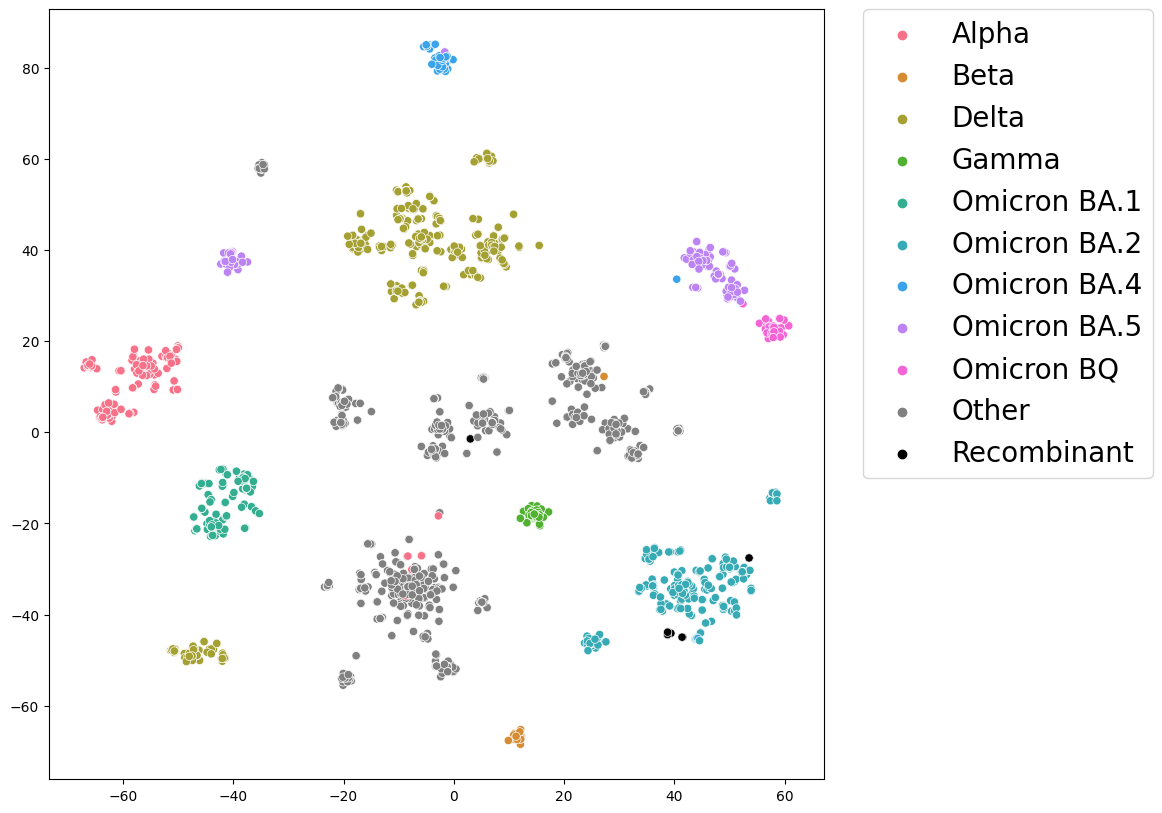

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
emb = out['embeddings'][-1]
_ = sns.scatterplot(x=emb[:,0], 
                    y=emb[:,1], 
                    hue=metadata['WHO Label'], 
                    palette=cmap_who,
                    hue_order=np.sort(labels_who),
                    ax=ax)
_ = plt.legend(prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#fig.savefig('Notebooks/tsne_sarscov2_2.png', dpi=600, bbox_inches='tight')

In [4]:
def make_attr(pca_obj, attrs):
    # Get the loadings from the PCA object
    loadings = pca_obj.components_ * np.sqrt(pca_obj.explained_variance_).reshape(-1, 1)
    attr_recon = np.matmul(loadings.T, attrs.T).T
    return attr_recon

attrs = out['attrs'][250][0]
attrs[np.isnan(attrs)] = 0 # remove bad attributions
attrs[attrs > 1] = 1 # clip attributions values
attrs[attrs < -1] = -1 # clip attributions values
attr_full = make_attr(pca_obj, attrs)

In [5]:
positions = np.array([int(x.split('_')[0]) for x in X_colnames])
new_bp = np.array([x.split('_')[1] for x in X_colnames])

with open("data/Covid19/NC_045512.2_sequence.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        print(record.id)
orig_bp = [record.seq[pos] for pos in positions]

NC_045512.2


In [6]:
# compute missing proportions of positions per lineage
lineage_df = pd.DataFrame({'lineage': [], 
                           'avg attribution': [], 
                           'avg feature': [], 
                           'position': [], 
                           'bp orig': [], 
                           'bp change': [], 
                           'col index': []})

for lineage in metadata['WHO Label'].unique():
    avg_attrs = np.abs(attr_full[metadata['WHO Label'] == lineage]).mean(0)
    avg_feats = np.abs(X[metadata['WHO Label'] == lineage]).mean(0)

    lineage_df = pd.concat([lineage_df,
                            pd.DataFrame({'lineage': [lineage]*avg_attrs.shape[0], 
                                          'avg attribution': avg_attrs, 
                                          'avg feature': avg_feats,
                                          'position': positions, 
                                          'bp orig': orig_bp,
                                          'bp change': new_bp,
                                          'col index': X_colnames})])
lineage_df['synonymous'] = lineage_df.apply(lambda row: row['bp orig'] == row['bp change'], axis=1)

In [7]:
genome_annotation_table = pd.read_excel('data/Covid19/genome_annotation.xlsx',
                                        sheet_name='Feuil1')

In [8]:
table = genome_annotation_table[genome_annotation_table['Krogan name'].isin(['SARS-CoV2 Spike',
                                                                             'SARS-CoV2 E',
                                                                             'SARS-CoV2 M',
                                                                             'SARS-CoV2 N'])][['Start Pos', 'End Pos']]
table['Protein'] = ['S', 'E', 'M', 'N']
table['Start Pos'] = table['Start Pos'].astype(int)
table['End Pos'] = table['End Pos'].astype(int)

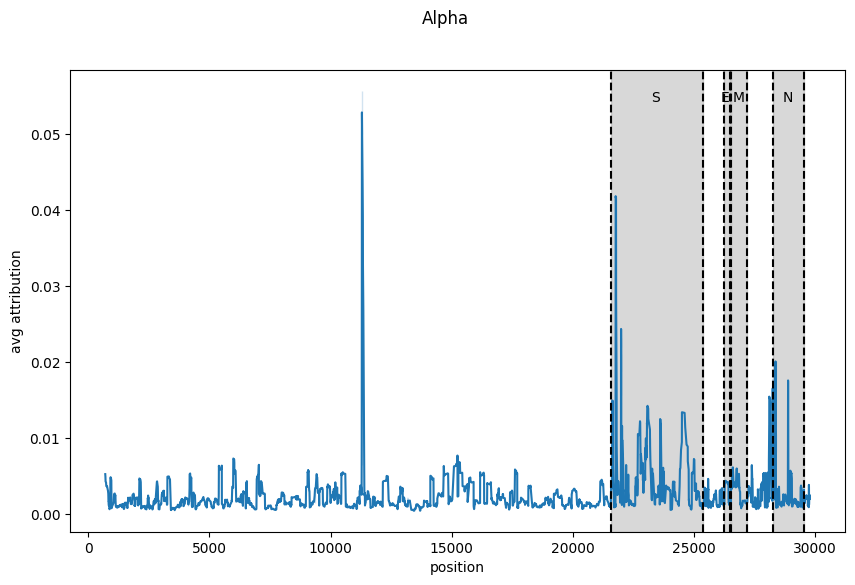

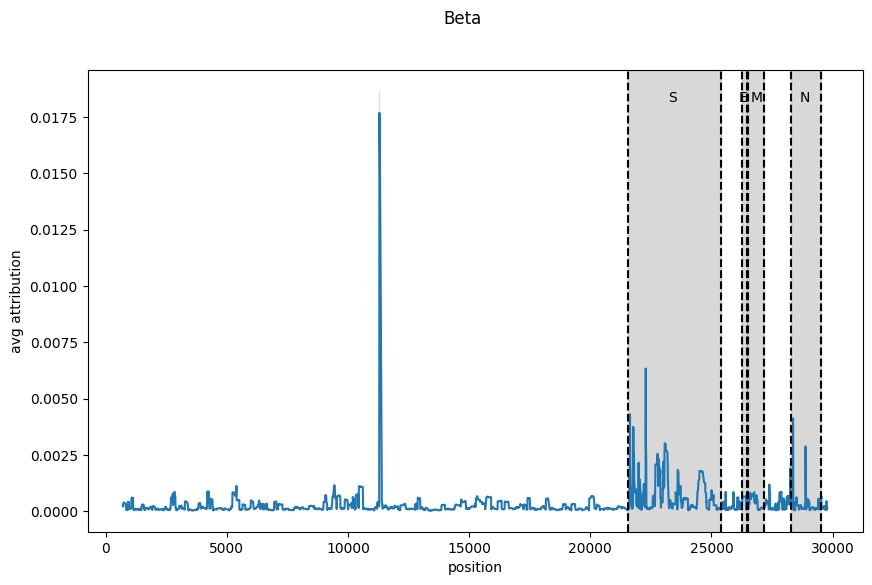

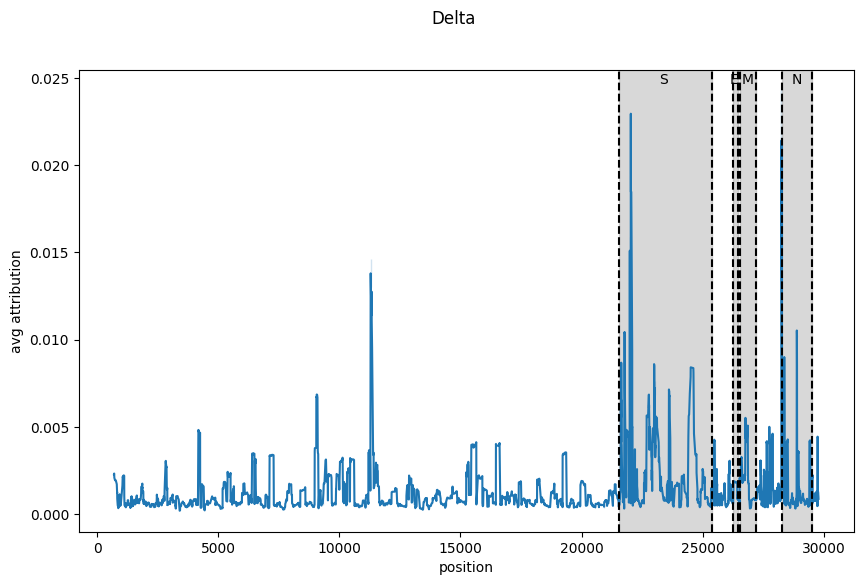

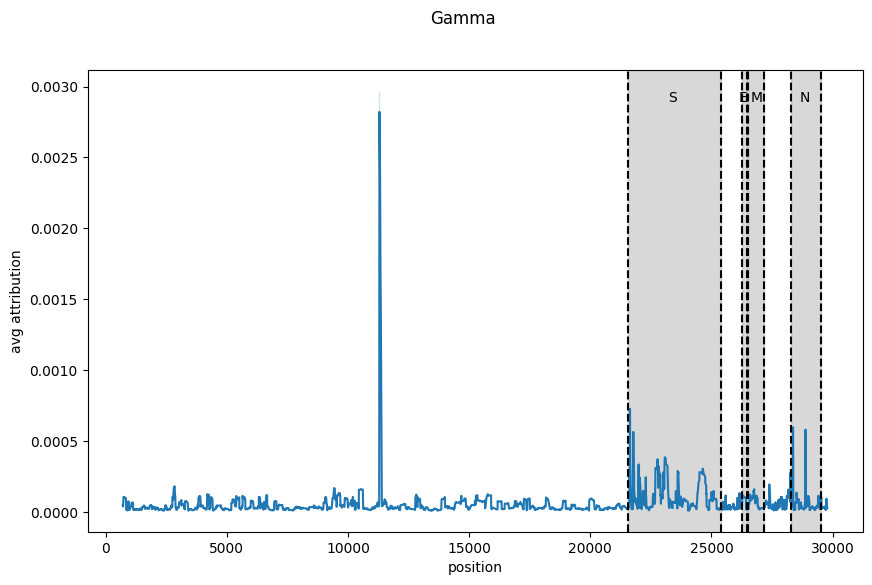

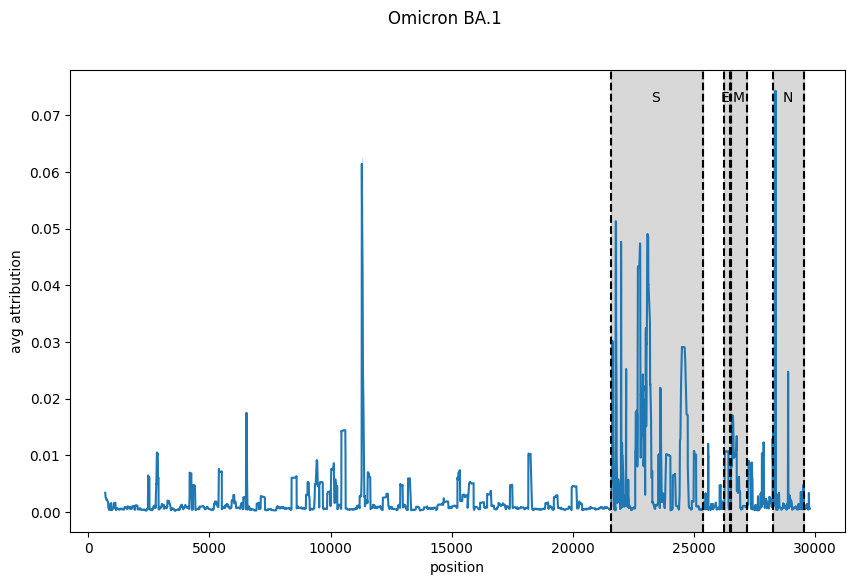

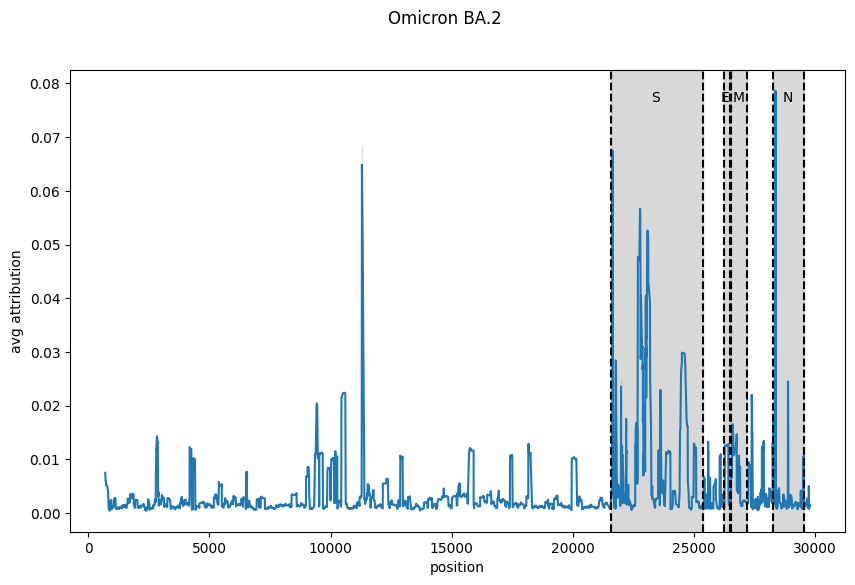

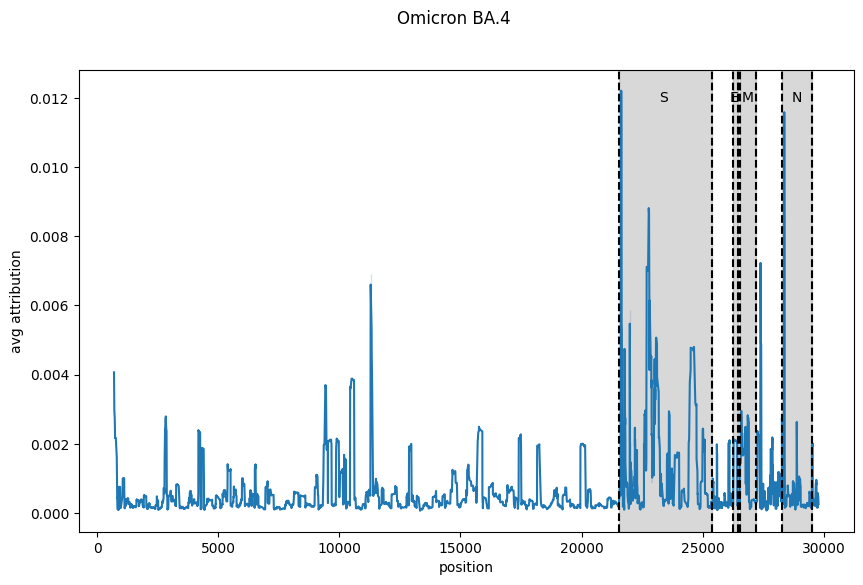

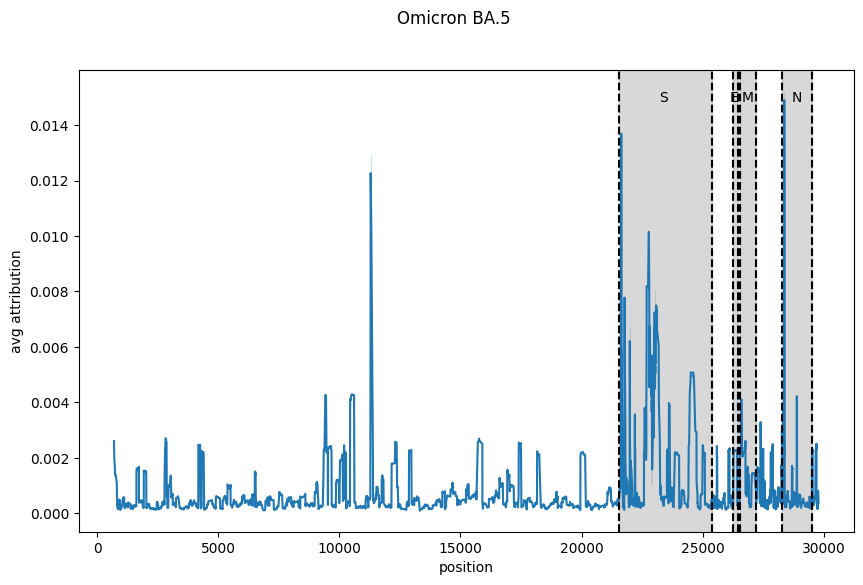

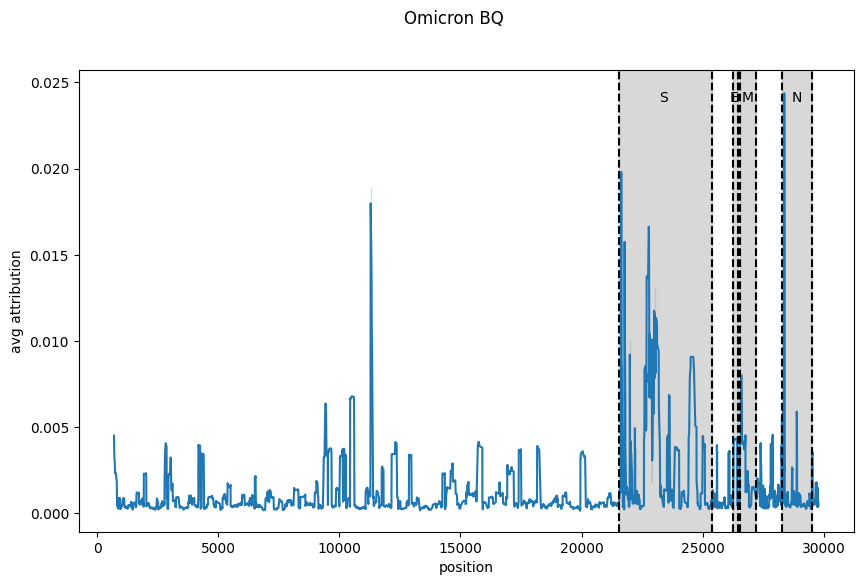

In [9]:
smoothing_amt = 99
for _lineage in np.sort(lineage_df['lineage'].unique()):
    # Ignore other since its not a real lineage
    if _lineage not in ['Other', 'Recombinant']:
        fig, ax = plt.subplots(figsize=(10, 6))
        smoothed_avg_attr = lineage_df[lineage_df['lineage'] == _lineage]['avg attribution'].rolling(window=10).mean().iloc[smoothing_amt:].reset_index()
        smoothed_avg_attr['position'] = positions[smoothing_amt:]
        # plot the original data and the rolling mean
        sns.lineplot(data=smoothed_avg_attr, x='position', y='avg attribution')
        plt.suptitle('{}'.format(_lineage))
        for index, row in table.iterrows():
            ax.axvline(x=row['Start Pos'], linestyle='--', color='black')
            ax.axvline(x=row['End Pos'], linestyle='--', color='black')
            midpoint = row['Start Pos'] + (row['End Pos'] - row['Start Pos'])/2 - 250
            ax.text(midpoint, smoothed_avg_attr['avg attribution'].max(), row['Protein'], fontsize=10, va='top')
            ax.axvspan(row['Start Pos'], row['End Pos'], color='gray', alpha=0.3)

## Differential Feat Analysis

In [10]:
#  Differential Feat Avg Analysis

# very simple. 1 = feature > 95th percentile value for exactly k classes. 0 otherwise.
perc = np.percentile(lineage_df['avg feature'], 95)
lineage_names = lineage_df['lineage'].unique()

vals_dict = {}
for i in range(1, lineage_names.shape[0]):
    vals_dict[i] = {lineage_name: [] for lineage_name in lineage_names}

    for pos in lineage_df['col index'].unique():
        ge_perc = (lineage_df[lineage_df['col index'] == pos]['avg feature'] > perc)
        if ge_perc.sum() == i:
            lineage_name = lineage_df[(lineage_df['col index'] == pos) & (lineage_df['avg feature'] > perc)]['lineage'].values[0]
            vals_dict[i][lineage_name].append(pos)

for i in range(1, lineage_names.shape[0]):
    lineage_df['feat in {} cluster'.format(i)] = np.zeros(lineage_df.shape[0])

for i in range(1, lineage_names.shape[0]):
    for lineage in vals_dict[i].keys():
        for pos in vals_dict[i][lineage]:
            lineage_df.loc[(lineage_df['lineage'] == lineage) & (lineage_df['col index']==pos), 'feat in {} cluster'.format(i)] = 1
lineage_df['position'] = lineage_df['position'].astype(int)

feat_in_cluster_df = pd.DataFrame()
for i in range(1, lineage_names.shape[0]):
    _tmp = pd.DataFrame({'attrs': lineage_df[lineage_df['feat in {} cluster'.format(i)] == 1]['avg attribution'],
                         'feats in cluster': [i]*(lineage_df['feat in {} cluster'.format(i)] == 1).sum()})
    feat_in_cluster_df = pd.concat([feat_in_cluster_df, _tmp])

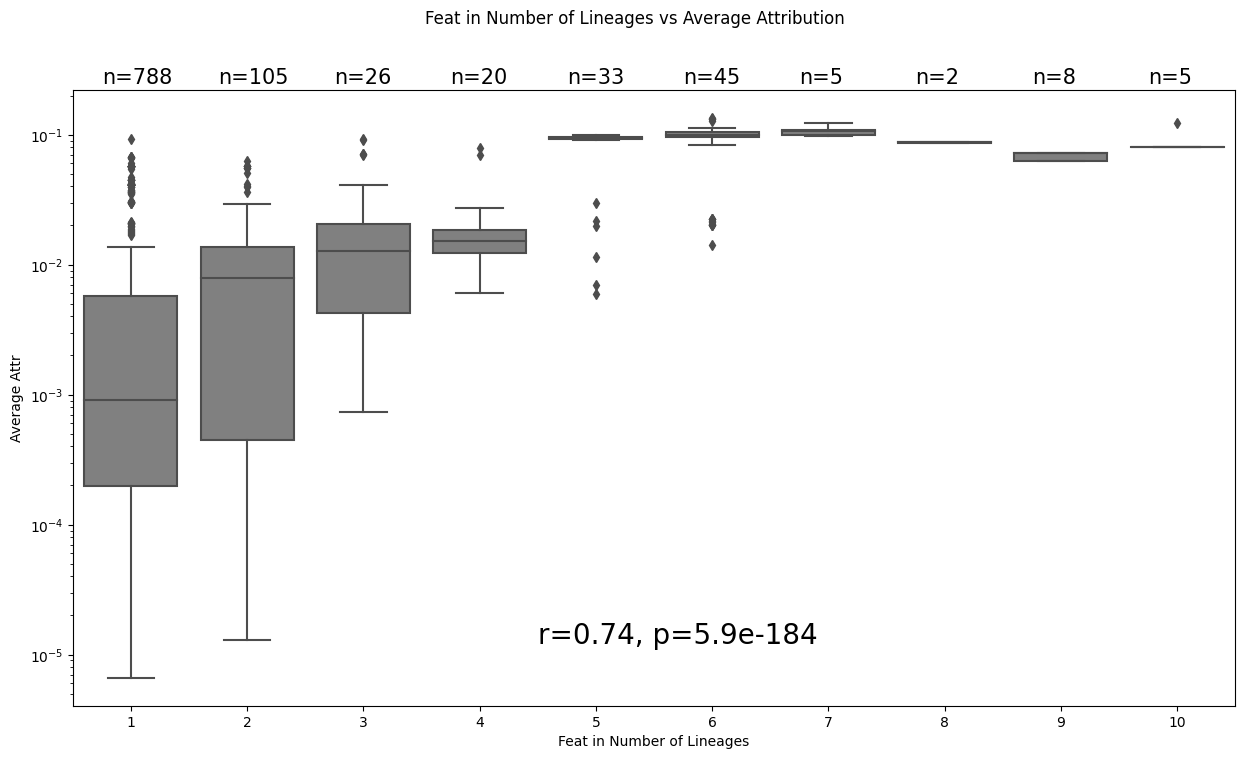

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=feat_in_cluster_df, x='feats in cluster', y='attrs', ax=ax, color='gray')
_ = ax.set_xlabel('Feat in Number of Lineages')
_ = ax.set_ylabel('Average Attr')
_ = plt.suptitle('Feat in Number of Lineages vs Average Attribution')
_ = ax.set(yscale="log")
r, p = scipy.stats.pearsonr(feat_in_cluster_df['feats in cluster'], feat_in_cluster_df['attrs'])
_ = ax.text(0.4, 0.1, 'r={:.2f}, p={:.2g}'.format(r, p), fontsize=20, transform=ax.transAxes)
for i, n in enumerate (feat_in_cluster_df.groupby('feats in cluster').count()['attrs'].values):
    _ = ax.text(i/10 + 0.025, 1.01, 'n={}'.format(n), fontsize=15, transform=ax.transAxes)
#fig.savefig('Notebooks/differential_analysis.png', dpi=600, bbox_inches='tight')

In [12]:
print('Appears in 10 lineages: ' + str(lineage_df[lineage_df['feat in 10 cluster']==1]['col index'].values))
print('Appears in 9 lineages: ' + str(lineage_df[lineage_df['feat in 9 cluster']==1]['col index'].values))
print('Appears in 8 lineages: ' + str(lineage_df[lineage_df['feat in 8 cluster']==1]['col index'].values))

Appears in 10 lineages: ['11288_-' '11289_-' '11290_-' '11291_-' '23063_T']
Appears in 9 lineages: ['11292_-' '11293_-' '11294_-' '11295_-' '11296_-' '28881_A' '28882_A'
 '28883_C']
Appears in 8 lineages: ['10029_T' '23604_A']


## Look at Markers

In [13]:
mutations = pd.read_csv('data/Covid19/annotatedMutations.txt', header=None, sep=',')
mutations[['Mutation Name', 'Full Position']] = mutations[1].str.split('\t', expand=True)
mutations = mutations.drop(columns=[1])
mutations['position'] = mutations['Full Position'].str[:-1]
mutations['bp change'] = mutations['Full Position'].str[-1:]
mutations = mutations[mutations['Full Position'] != 'DEL'] #ignore deletions
mutations.loc[:, 'lineage'] = pd.Categorical(mutations[0]).rename_categories({'BA.1': 'Omicron BA.1', 
                                                                              'BA.2': 'Omicron BA.2', 
                                                                              'BA.4': 'Omicron BA.4', 
                                                                              'BA.5': 'Omicron BA.5'})
mutations = mutations.drop(columns=[0])
mutations['position'] = mutations['position'].astype(int)

In [14]:
is_marker = np.zeros(lineage_df.shape[0], bool)
for mut in mutations.iterrows():
    if lineage_df[(lineage_df['position'] == mut[1]['position']) & (lineage_df['bp change'] == mut[1]['bp change']) & (lineage_df['lineage'] == mut[1]['lineage'])].shape[0] >= 1:
        is_marker[(lineage_df['position'] == mut[1]['position']) & (lineage_df['bp change'] == mut[1]['bp change']) & (lineage_df['lineage'] == mut[1]['lineage'])] = 1
lineage_df['is_marker'] = is_marker

In [15]:
colors = sns.color_palette("Greys", 2)[::-1]
levels = [True, False]
cmap = {}
for color,level in zip(colors, levels):
    cmap[level] = color

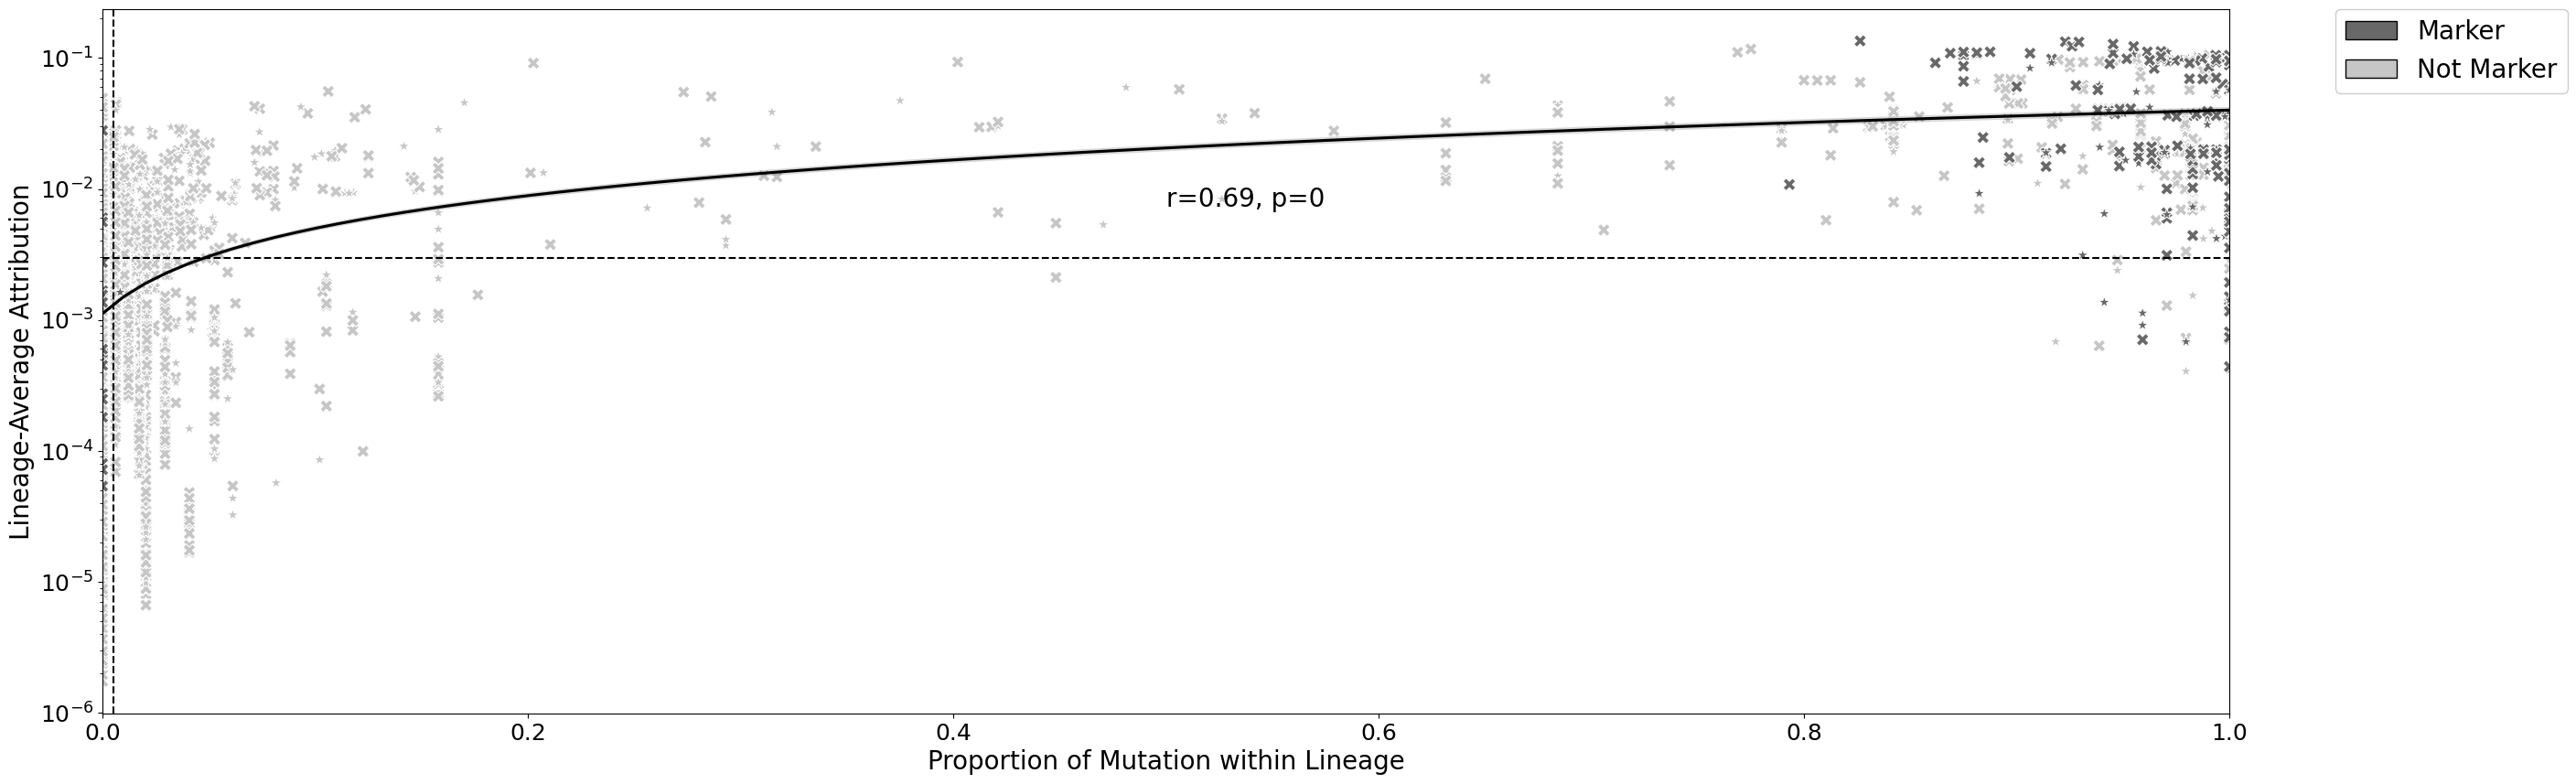

In [16]:
legend_elements = [Patch(facecolor=color, edgecolor='black', label='Color Patch') for color in colors]

fig, ax = plt.subplots(figsize=(30, 10))

# Create the figure
sns.scatterplot(x='avg feature',
                y='avg attribution',
                hue='is_marker',
                data=lineage_df[~lineage_df['is_marker']],
                ax=ax,
                palette=cmap,
                hue_order=levels,
                style='synonymous', markers=['*', 'X'], style_order=[True, False], s=100)
sns.scatterplot(x='avg feature',
                y='avg attribution',
                hue='is_marker',
                data=lineage_df[lineage_df['is_marker']],
                ax=ax,
                palette=cmap,
                hue_order=levels,
                style='synonymous', markers=['*', 'X'], style_order=[True, False], s=100)

perc_attr = np.percentile(lineage_df['avg attribution'], 90)
perc_feat = np.percentile(lineage_df['avg feature'], 90)

plt.axhline(y=perc_attr, color='black', linestyle='--')
plt.axvline(x=perc_feat, color='black', linestyle='--')
#ax.fill_between([perc_attr, 1.1], 0.5, 1.05, alpha=0.3, color='#F5F5F5')

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
_ = plt.legend(loc='upper left',
               borderaxespad=0,
               handles=legend_elements,
               prop={'size': 20},
               labels=['Marker', 'Not Marker'],
               framealpha=1, bbox_to_anchor=(1.05, 1))

r, p = scipy.stats.pearsonr(lineage_df['avg feature'], lineage_df['avg attribution'])
_ = ax.text(0.5, 0.72, 'r={:.2f}, p={:.2g}'.format(r, p), fontsize=20, transform=ax.transAxes)

sns.regplot(x='avg feature',
            y='avg attribution',
            data=lineage_df,
            scatter=False,
            ax=ax, line_kws={'color':'black'})

plt.yscale('log')
#_ = plt.xlim((-0.01, 1.1))
#_ = plt.ylim((5e-4, 1.05))
_ = ax.set_xlabel('Proportion of Mutation within Lineage', size=20)
_ = ax.set_ylabel('Lineage-Average Attribution', size=20)

#fig.savefig('Notebooks/attr_vs_feat_vals_with_markers_final.png', dpi=600, bbox_inches='tight')

## Compare Attributions versus Frequencies

In [17]:
feat_perc = np.percentile(lineage_df['avg feature'], 90)
attr_perc = np.percentile(lineage_df['avg attribution'], 90)

In [18]:
print('Num markers: {}'.format(lineage_df['is_marker'].sum()))
print('Number of markers with high frequency: {}'.format(lineage_df[lineage_df['avg feature'] > feat_perc]['is_marker'].sum()))
print('Number of markers with high attribution: {}'.format(lineage_df[lineage_df['avg attribution'] > attr_perc]['is_marker'].sum()))
print('Number of markers with high frequency and high attribution: {}'.format(lineage_df[(lineage_df['avg attribution'] > attr_perc) & (lineage_df['avg feature'] > feat_perc)]['is_marker'].sum()))
print('Number of high frequency markers with low attribution: {}'.format(lineage_df[(lineage_df['avg attribution'] < attr_perc) & (lineage_df['avg feature'] > feat_perc)]['is_marker'].sum()))
print('Number of low frequency markers with high attribution: {}'.format(lineage_df[(lineage_df['avg attribution'] > attr_perc) & (lineage_df['avg feature'] < feat_perc)]['is_marker'].sum()))
print('Number of low frequency and low attribution markers: {}'.format(lineage_df[(lineage_df['avg attribution'] < attr_perc) & (lineage_df['avg feature'] < feat_perc)]['is_marker'].sum()))

Num markers: 271
Number of markers with high frequency: 252
Number of markers with high attribution: 229
Number of markers with high frequency and high attribution: 226
Number of high frequency markers with low attribution: 26
Number of low frequency markers with high attribution: 3
Number of low frequency and low attribution markers: 16


In [19]:
metadata.groupby(['WHO Label']).count()['UNK Date']

WHO Label
Alpha           194
Beta             34
Delta           483
Gamma            49
Omicron BA.1    160
Omicron BA.2    311
Omicron BA.4     58
Omicron BA.5    164
Omicron BQ       48
Other           854
Recombinant      19
Name: UNK Date, dtype: int64

In [20]:
lineage_df[(lineage_df['avg attribution'] < attr_perc) & (lineage_df['avg feature'] > feat_perc) & (lineage_df['is_marker'])][['lineage', 'position', 'bp orig', 'bp change']]

,lineage,position,bp orig,bp change
1991,Delta,22029,G,G
1335,Beta,14408,T,T
2194,Beta,23403,T,G
443,Gamma,3828,A,T
602,Gamma,5648,A,C
1335,Gamma,14408,T,T
1509,Gamma,17259,T,T
1874,Gamma,21614,T,T
1879,Gamma,21621,C,A
1894,Gamma,21638,C,T


## What about "Haplotype defining" mutations?

In [21]:
# Haplotype defining mutations
haplo_pos = set([313,1059,1163,7851,10029,14805,15240,19220,21846,21987,22227,22917,22992,22995,23055,23063,23271,23403,23604,25563,28095,28144,28881,28882,28883])

feat_perc = np.percentile(lineage_df['avg feature'], 90)
attr_perc = np.percentile(lineage_df['avg attribution'], 90)

In [22]:
# attr and frequency hits
attr_pos = set(lineage_df[(lineage_df['avg attribution'] > attr_perc)].position)
feat_pos = set(lineage_df[(lineage_df['avg feature'] > feat_perc)].position)

In [23]:
print('percent of haplotype defining mutations with high attribution: {}'.format(len(haplo_pos.intersection(attr_pos))/len(haplo_pos)))
print('positions missed: {}'.format(haplo_pos.difference(attr_pos)))

percent of haplotype defining mutations with high attribution: 0.96
positions missed: {1163}


In [24]:
print('percent of haplotype defining mutations with high frequency: {}'.format(len(haplo_pos.intersection(feat_pos))/len(haplo_pos)))

percent of haplotype defining mutations with high frequency: 1.0
